In [133]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import time


def rms(x):
    """
    Вычисление коэффициента масштабирования
    
    Параметры
    -----------
    x - все точки фигуры
    
    Возвращаемое значение
    -----------
    коэффициент масштабирования
    """
    return np.sqrt(np.mean(x**2, axis=0))


@delayed
def procrustes_computation(a1, arr, i):
    """
    Вычисление расстояний между фигурами
    
    Параметры
    -----------
    arr - массив всех фигур
    data - сохраняем все расстояния для одной фигуры в матрице расстояний
    a1 - референсная фигура
    center_a1 - центр референсной фигуры
    scale_a1 - коэффициент масштабирования для референсной фигуры
    center_a2 - аналогично center_a1 для остальных фигур
    scale_a2 - аналогично scale_a1 для остальных фигур
    M, U, VT - повороты
    rotated - повёрнутая фигура (не референсная)
    
    Возвращаемое значение
    -----------
    data - массив растояний до одной фигуры
    """
    copy_arr = np.copy(arr)
    data = []
    for j in range(i+1, len(arr)):
        center_a1 = a1.mean(axis=0)
        a1 -= center_a1
        scale_a1 = rms(a1)
        a1 /= scale_a1

        center_a2 = copy_arr[j].mean(axis=0)
        copy_arr[j] -= center_a2
        scale_a2 = rms(copy_arr[j])
        copy_arr[j] /= scale_a2

        M = copy_arr[j].T @ a1
        U, _, VT = np.linalg.svd(M)
        R = U @ VT
        rotated = a1 @ R.T
        data += [np.linalg.norm(rotated - copy_arr[j], axis=1).mean()]
    return data
    

def procrustes_load(arr, name):
    """
    Кластеризация, построение графиков, создание задач для распараллеливания
    
    Параметры
    -----------
    display_name - имя текущего обрабатываемого датасета
    tasks - массив задач
    distances - матрица расстояний между фигурами
    pool - ресурсы для распараллеливания
    result - массив с результатами со всех ядер (после распраллеливания)
    px - разрешение картинок в matplotlib
    pca - класс PCA из sklearn
    projection - матрица из двумерных векторов (проекция)
    kmeans - результат кластеризации методом K-средних
    start - время старта распараллеливания
    """
    
    display_name = name.split("_")[-1].split(".")[0]
    print(f"Dataset: {display_name}")
    
    tasks = []
    for i in range(len(arr)):
        tasks.append(i)
            
    distances = np.zeros((len(arr), len(arr)))
    
    start = time.time()
        
    pool = Parallel(n_jobs=8, prefer='processes')
    result = pool(procrustes_computation(arr[i], arr, i) for i in tasks)
    
    result = [i for sub in result for i in sub]
    
    k = 0
    for i in range(len(arr)):
        for j in range(i+1, len(arr)):
            distances[i][j] = result[k]
            k += 1
            
    for i in range(len(arr)):
        for j in range(len(arr)):
            distances[j][i] = distances[i][j]
            
    with open('{}_distance_matrix.npy'.format(display_name), 'wb') as f:
        np.save(f, distances)
    
    print(f"Time spent for {display_name} dataset: {round(time.time() - start, 4)} sec")
    
    px = 1/plt.rcParams['figure.dpi']
    
    plt.clf()
    fig, ax = plt.subplots(1, 1, figsize=(600*px, 600*px))
    img = ax.imshow(distances)
    ax.invert_yaxis()
    ax.title.set_text(f"Distance matrix for {display_name} dataset")
    fig.colorbar(img)
    plt.show()
    
    pca = PCA(n_components=2)
    projection = pca.fit_transform(distances)
    kmeans = KMeans(n_clusters=3, random_state=0).fit(projection)
    class_names = ["class 1", "class 2", "class 3"]
    
    plt.clf()
    fig, ax = plt.subplots(1, 1, figsize=(600*px, 600*px))
    ax.scatter(*projection.T)
    ax.title.set_text(f"Projection for {display_name} dataset")
    plt.show()
    
    plt.clf()
    fig, ax = plt.subplots(1, 1, figsize=(600*px, 600*px))
    ax.scatter(*projection.T, c=kmeans.labels_)
    ax.scatter(*np.array(kmeans.cluster_centers_).T, s=80, c='r', marker="o")
    ax.title.set_text(f"Clasterization for {display_name} dataset")
    for i in range(len(class_names)):
        ax.annotate(class_names[i], (kmeans.cluster_centers_[i][0]+0.2, kmeans.cluster_centers_[i][1]))
    plt.show()
    
    plt.clf()
    fig, ax = plt.subplots(3, 3, figsize=(1000*px, 1000*px))
    for i in range(len(arr)):
        if kmeans.labels_[i] == 0:
            ax[0][0].plot(*np.array(arr[i][:,:2]).T, alpha=0.2)
            ax[0][1].plot(*np.array(arr[i][:,::2]).T, alpha=0.2)
            ax[0][2].plot(*np.array(arr[i][:,1:3]).T, alpha=0.2)
        if kmeans.labels_[i] == 1:
            ax[1][0].plot(*np.array(arr[i][:,:2]).T, alpha=0.2)
            ax[1][1].plot(*np.array(arr[i][:,::2]).T, alpha=0.2)
            ax[1][2].plot(*np.array(arr[i][:,1:3]).T, alpha=0.2)
        if kmeans.labels_[i] == 2:
            ax[2][0].plot(*np.array(arr[i][:,:2]).T, alpha=0.2)
            ax[2][1].plot(*np.array(arr[i][:,::2]).T, alpha=0.2)
            ax[2][2].plot(*np.array(arr[i][:,1:3]).T, alpha=0.2)
    ax[0][0].title.set_text('Class 1 (X-Y)')
    ax[0][1].title.set_text('Class 1 (X-Z)')
    ax[0][2].title.set_text('Class 1 (Y-Z)')
    ax[1][0].title.set_text('Class 2 (X-Y)')
    ax[1][1].title.set_text('Class 2 (X-Z)')
    ax[1][2].title.set_text('Class 2 (Y-Z)')
    ax[2][0].title.set_text('Class 3 (X-Y)')
    ax[2][1].title.set_text('Class 3 (X-Z)')
    ax[2][2].title.set_text('Class 3 (Y-Z)')
    plt.show()

Dataset: tiny
Time spent for tiny dataset: 1.095 sec


<Figure size 432x288 with 0 Axes>

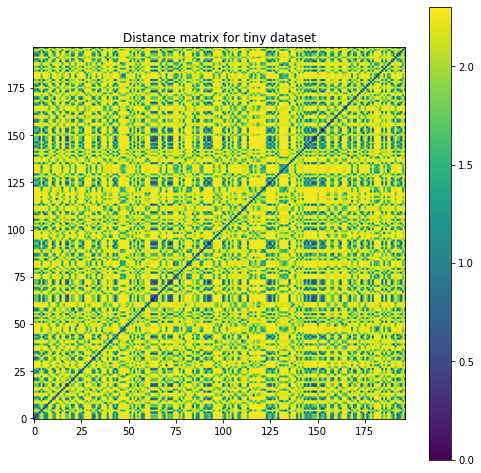

<Figure size 432x288 with 0 Axes>

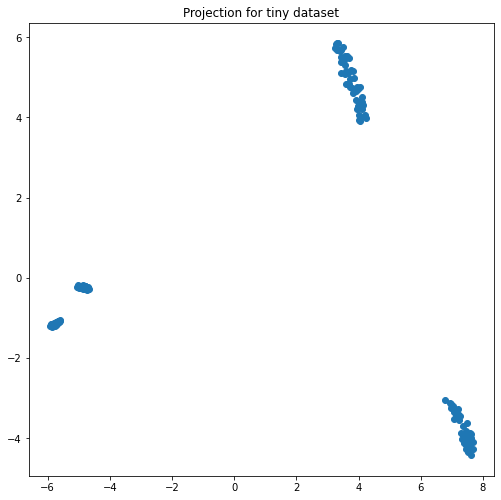

<Figure size 432x288 with 0 Axes>

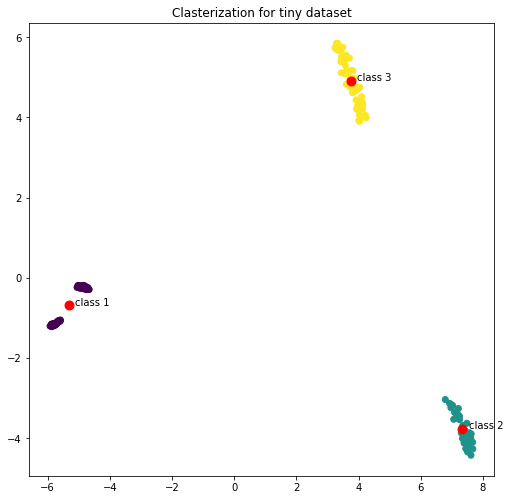

<Figure size 432x288 with 0 Axes>

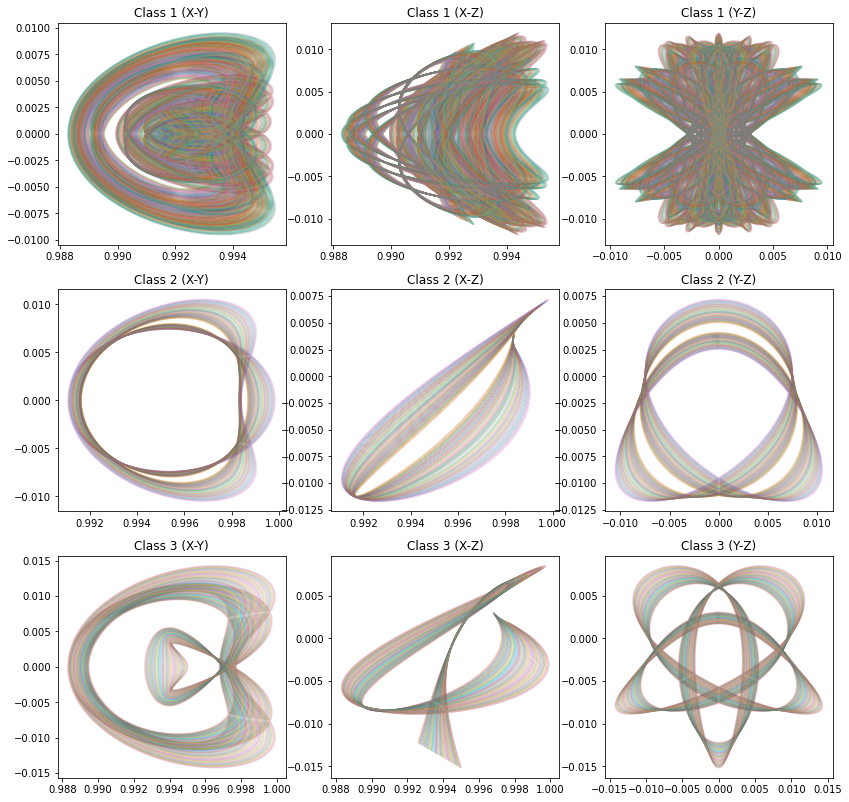

Dataset: small
Time spent for small dataset: 5.9725 sec


<Figure size 432x288 with 0 Axes>

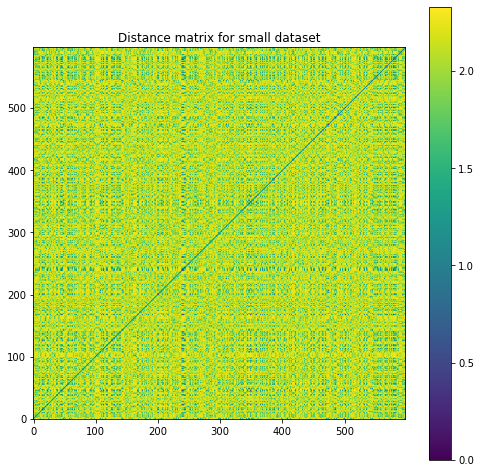

<Figure size 432x288 with 0 Axes>

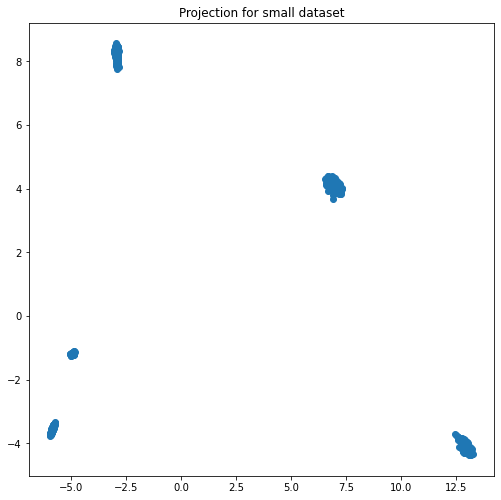

<Figure size 432x288 with 0 Axes>

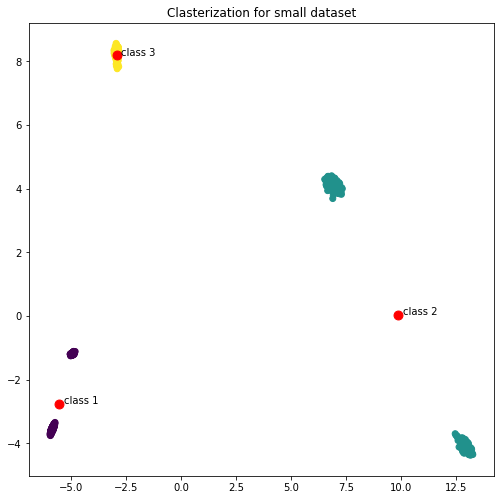

<Figure size 432x288 with 0 Axes>

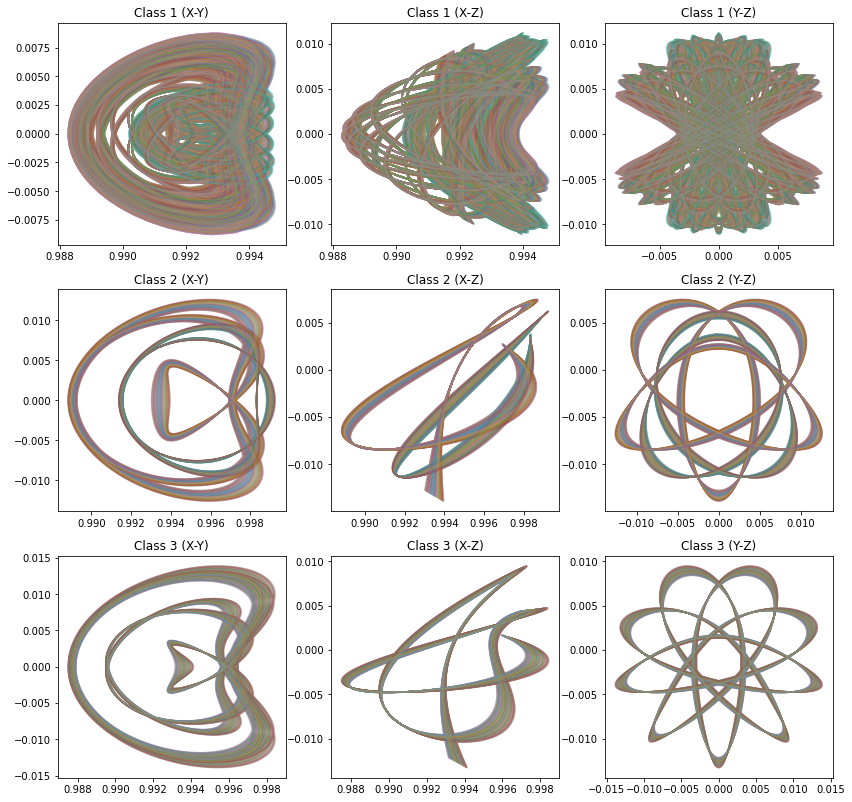

Dataset: medium
Time spent for medium dataset: 99.4091 sec


<Figure size 432x288 with 0 Axes>

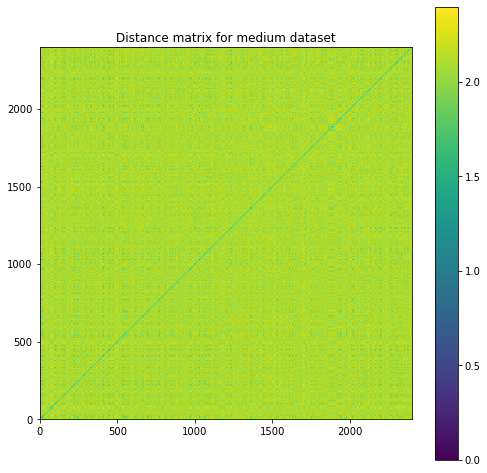

<Figure size 432x288 with 0 Axes>

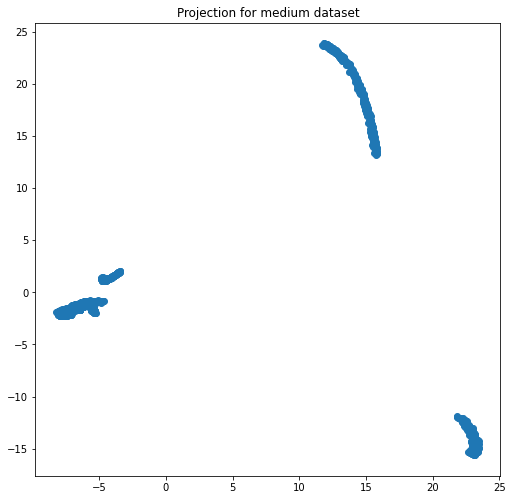

<Figure size 432x288 with 0 Axes>

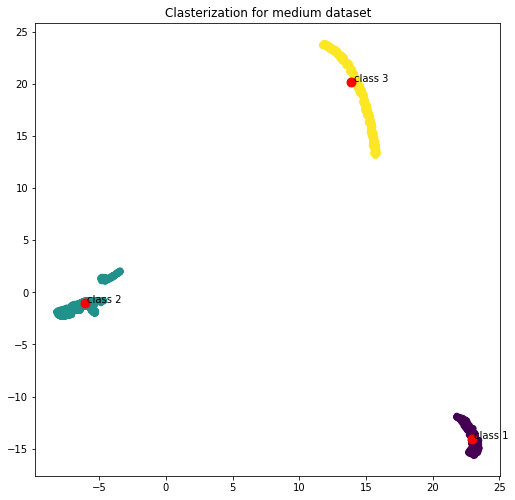

<Figure size 432x288 with 0 Axes>

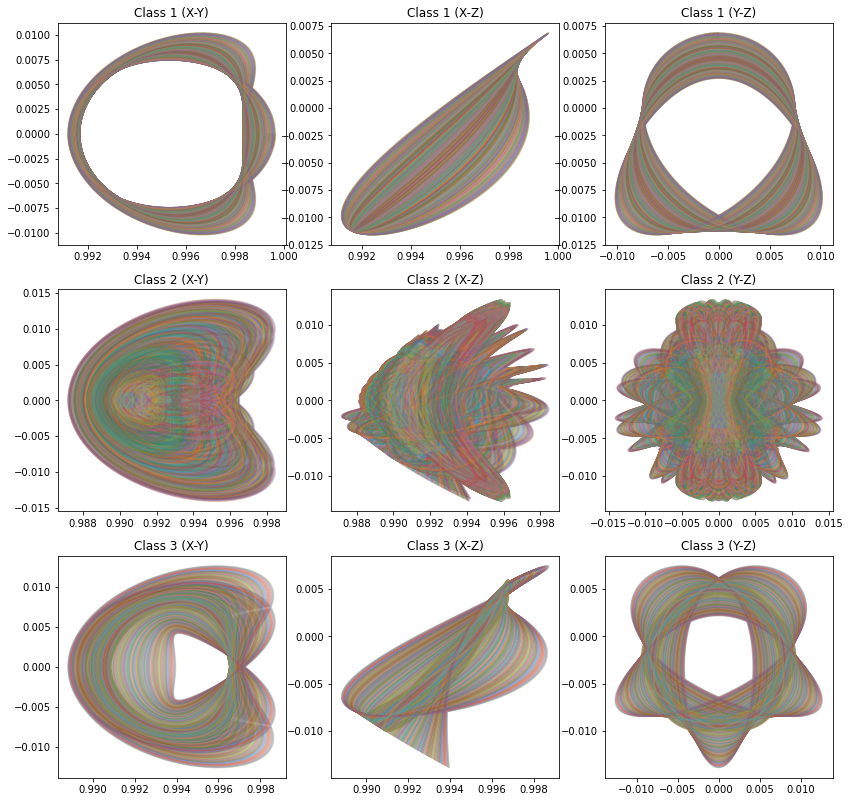

Dataset: large
Time spent for large dataset: 642.6775 sec


<Figure size 432x288 with 0 Axes>

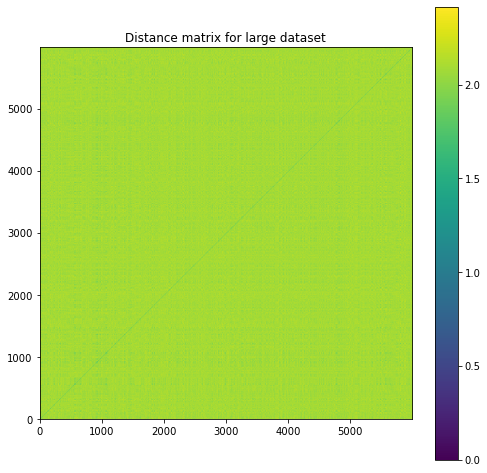

<Figure size 432x288 with 0 Axes>

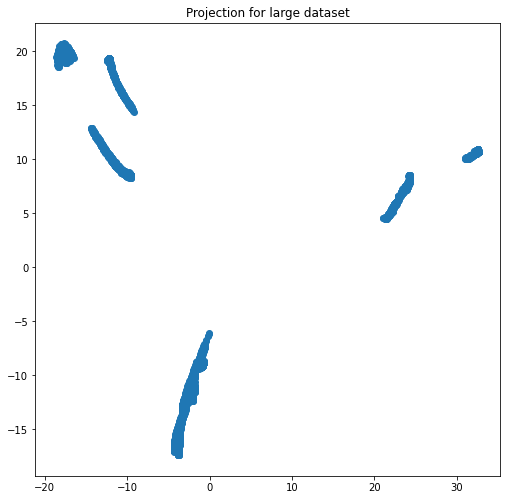

<Figure size 432x288 with 0 Axes>

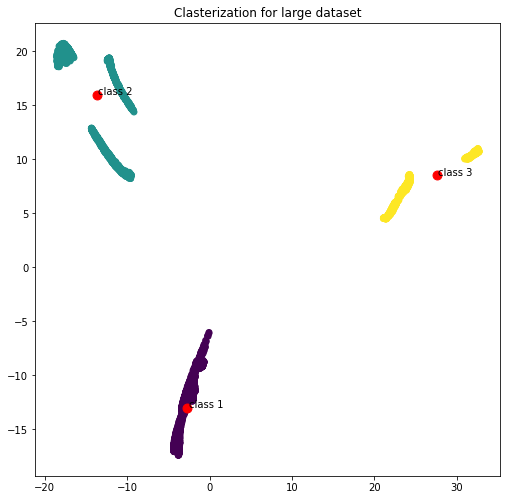

<Figure size 432x288 with 0 Axes>

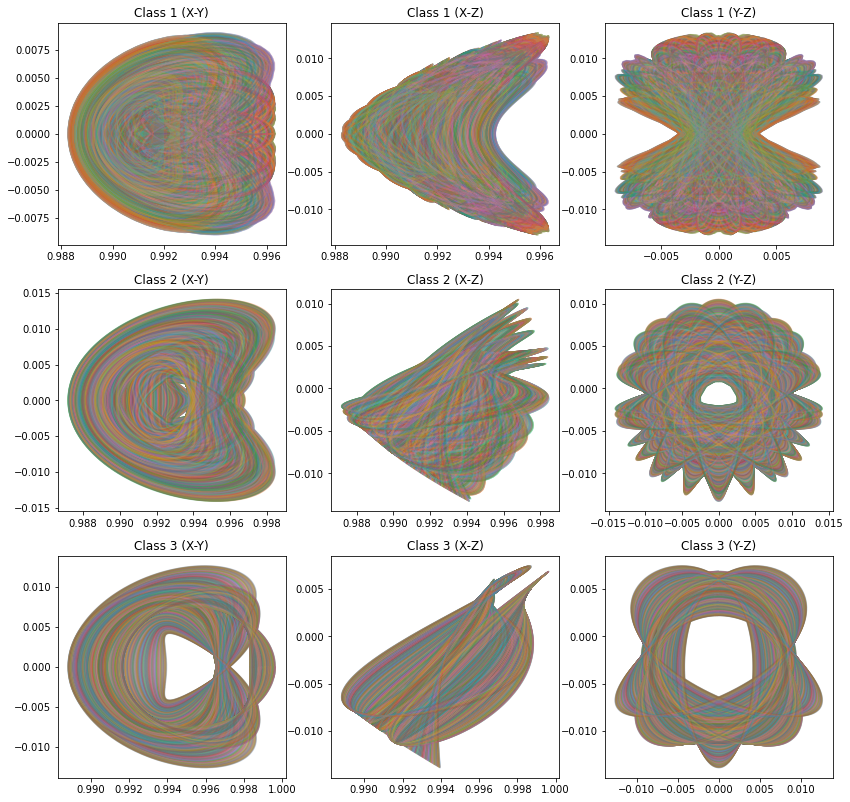

Dataset: xlarge
Time spent for xlarge dataset: 4713.6973 sec


<Figure size 432x288 with 0 Axes>

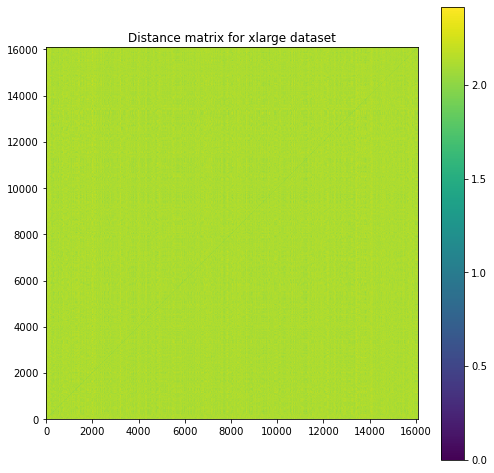

<Figure size 432x288 with 0 Axes>

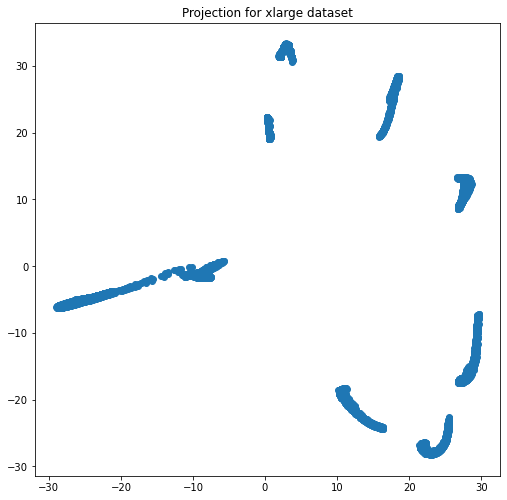

<Figure size 432x288 with 0 Axes>

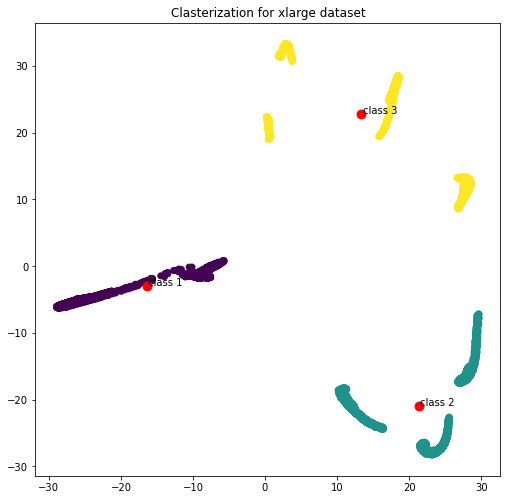

<Figure size 432x288 with 0 Axes>

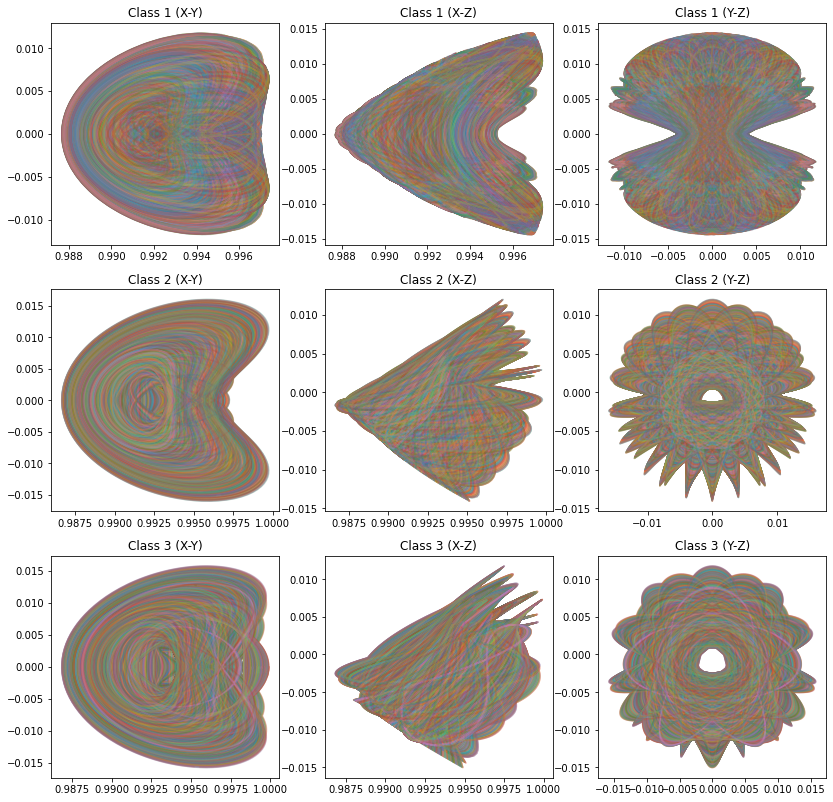

In [134]:
datasets = ["procrustus_problem_dataset_tiny.npy", "procrustus_problem_dataset_small.npy", "procrustus_problem_dataset_medium.npy", "procrustus_problem_dataset_large.npy", "procrustus_problem_dataset_xlarge.npy"]
for name in datasets:
    array = np.load(name)
    procrustes_load(array, name)